# CNN Classifier Training Example

This notebook demonstrates a basic 4-layer CNN trained to classify spectra from galaxies and galaxies + SNe Ia within 2 weeks (plus/minus) of max light.

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13725943192763979439
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11338085172
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 4869000886804023607
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:88:00.0, compute capability: 3.7"
]


In [2]:
# from desispec.io import read_spectra
# from desitrip.preproc import rebin_flux, rescale_flux

from glob import glob
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import platform

mpl.rc('font', size=14)

## Input Spectra



In [3]:
import pickle 

with open('host_flux.data', 'rb') as filehandle:
    host_flux = pickle.load(filehandle)

with open('snia_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snia_flux = pickle.load(filehandle)

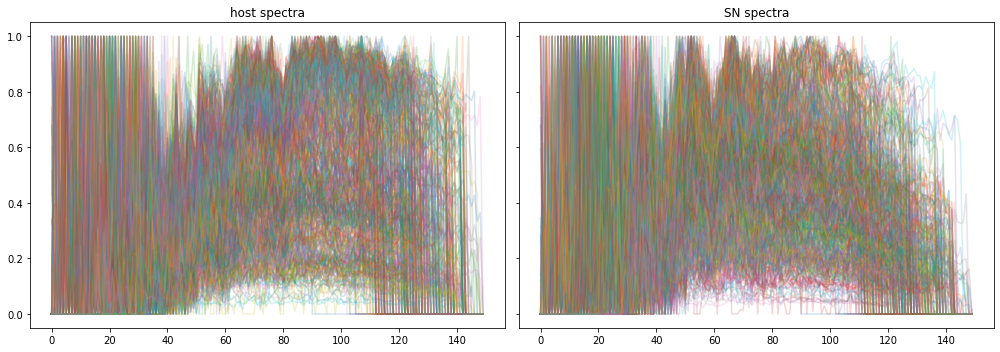

In [4]:
nhost, nbins = host_flux.shape
nsnia, nbins = snia_flux.shape

nhost, nsnia, nbins

### Plot Spectra to Check Output

fig, axes = plt.subplots(1,2, figsize=(14,5), sharex=True, sharey=True)

for i in range(0,500):
    
    ax = axes[0]
    ax.plot(host_flux[i], alpha=0.2)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
axes[0].set_title('host spectra')
axes[1].set_title('SN spectra')

fig.tight_layout()


In [5]:
### Set up Training Sets and Labels

# 0. "host" spectra based only on BGS templates
# 1. "snia" spectra based on BGS + SN Ia templates

x = np.concatenate([host_flux, snia_flux]).reshape(-1, nbins, 1)
y = np.concatenate([np.zeros(nhost), np.ones(nsnia)])

In [6]:
nhost, nbins = host_flux.shape
nsnia, nbins = snia_flux.shape

nhost, nsnia, nbins

(9969, 9964, 150)

In [13]:
x = np.concatenate([host_flux, snia_flux]).reshape(-1, nbins, 1)
y = np.concatenate([np.zeros(nhost), np.ones(nsnia)])

## CNN Network Setup

Train network with TensorFlow+Keras.

In [7]:
import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

In [22]:
def network(input_shape, learning_rate=0.0005, reg=0.0032, dropout=0.7, seed=None):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')
    
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(1, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [23]:
model = network((nbins, 1))

W0813 15:41:33.937721 46960479437696 nn_ops.py:4220] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


## Train and Test

Split the data into training and testing (validation) samples and fit the network weights.

In [24]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
x = np.concatenate([host_flux, snia_flux]).reshape(-1, nbins, 1)
y = np.concatenate([np.zeros(nhost), np.ones(nsnia)])

# <font color='blue'> 60, 20, 20 split

In [25]:
a, x_test, b , y_test = train_test_split(x, y, test_size=0.2)

In [26]:
x_train, x_cv, y_train, y_cv = train_test_split(a, b, test_size=0.25)

In [27]:
len(x_train), len(x_test), len(x_cv),len(y_train), len(y_test), len(y_cv)

(11959, 3987, 3987, 11959, 3987, 3987)

In [28]:
hist = model.fit(x_train, y_train, batch_size=65, epochs=50, validation_data=(x_test, y_test), shuffle=True)

Train on 11959 samples, validate on 3987 samples
Epoch 1/50
11959/11959 [==============================] - 3s 238us/sample - loss: 1.6402 - acc: 0.7120 - val_loss: 1.5211 - val_acc: 0.4966
Epoch 2/50
11959/11959 [==============================] - 2s 165us/sample - loss: 1.1276 - acc: 0.8097 - val_loss: 1.0192 - val_acc: 0.8249
Epoch 3/50
11959/11959 [==============================] - 2s 165us/sample - loss: 0.8808 - acc: 0.8444 - val_loss: 0.7855 - val_acc: 0.8623
Epoch 4/50
11959/11959 [==============================] - 2s 165us/sample - loss: 0.7317 - acc: 0.8578 - val_loss: 0.6748 - val_acc: 0.8600
Epoch 5/50
11959/11959 [==============================] - 2s 165us/sample - loss: 0.6359 - acc: 0.8648 - val_loss: 0.5834 - val_acc: 0.8794
Epoch 6/50
11959/11959 [==============================] - 2s 165us/sample - loss: 0.5608 - acc: 0.8747 - val_loss: 0.5483 - val_acc: 0.8706
Epoch 7/50
11959/11959 [==============================] - 2s 165us/sample - loss: 0.5086 - acc: 0.8816 - val_lo

## Performance

### Loss and Accuracy

Plot loss and accuracy as a function of epoch.

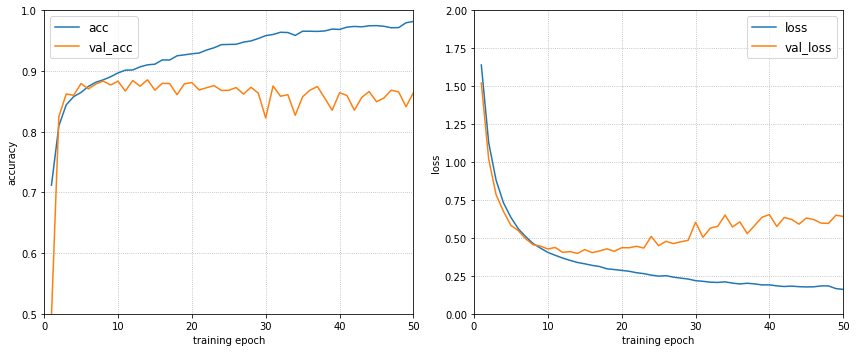

In [29]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['acc'], label='acc')
ax.plot(epochs, hist.history['val_acc'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.5,1.0))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
       ylim=(0.,2.0))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

fig.tight_layout();

### ROC Curve and Precision-Recall

In [34]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
y_pred = model.predict(x_cv).ravel()
fpr, tpr, thresholds = roc_curve(y_cv, y_pred)
pre, rec, _ = precision_recall_curve(y_cv, y_pred)

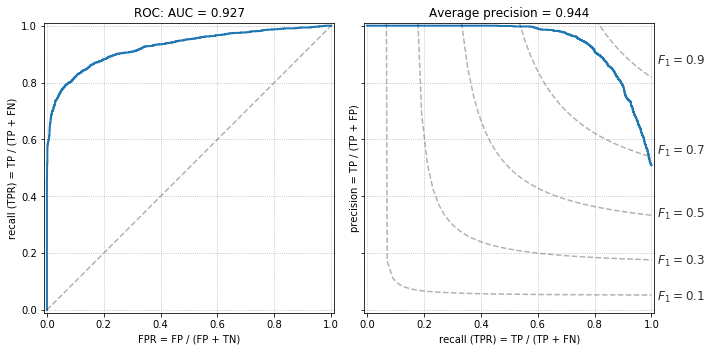

In [35]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

ax = axes[0]
ax.plot(fpr, tpr, lw=2)
ax.plot((0,1), (0,1), 'k--', alpha=0.3)
ax.grid(ls=':')
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(auc(fpr, tpr)),
       aspect='equal')

ax = axes[1]
ax.plot(rec, pre, lw=2)
f_scores = np.linspace(0.1, 0.9, num=5)
lines = []
labels = []
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_cv, y_pred)),
       aspect='equal')

fig.tight_layout()

### Confusion Matrix

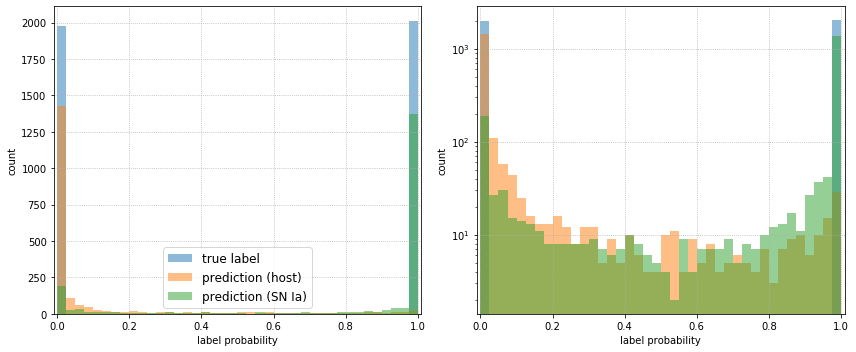

In [36]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

ax = axes[0]
ybins = np.linspace(0,1,41)
ax.hist(y_cv, bins=ybins, alpha=0.5, label='true label')
ax.hist(y_pred[y_cv==0], bins=ybins, alpha=0.5, label='prediction (host)')
ax.hist(y_pred[y_cv==1], bins=ybins, alpha=0.5, label='prediction (SN Ia)')
ax.grid(ls=':')
ax.set(xlabel='label probability',
       xlim=(-0.01, 1.01),
       ylabel='count')
ax.legend(fontsize=12, loc='best')

ax = axes[1]
ybins = np.linspace(0,1,41)
ax.hist(y_cv, bins=ybins, alpha=0.5, label='true label')
ax.hist(y_pred[y_cv==0], bins=ybins, alpha=0.5, label='prediction (host)')
ax.hist(y_pred[y_cv==1], bins=ybins, alpha=0.5, label='prediction (SN Ia)', log=True)
ax.grid(ls=':')
ax.set(xlabel='label probability',
       xlim=(-0.01, 1.01),
       ylabel='count')

fig.tight_layout()

## <font color='red'>CM with y_pred > 0.5</font> 

In [37]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_cv, y_pred > 0.5)
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

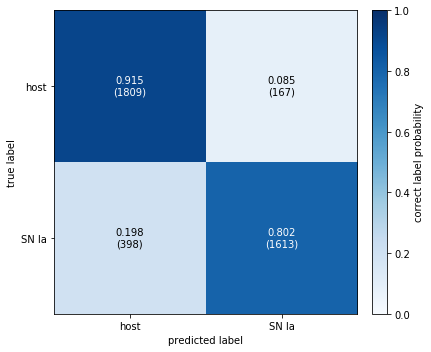

In [39]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label probability')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=['host', 'SN Ia'],
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=['host', 'SN Ia'])

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([1.5,-.5])
fig.tight_layout()

## <font color='red'>CM with y_pred > 0.9</font> 

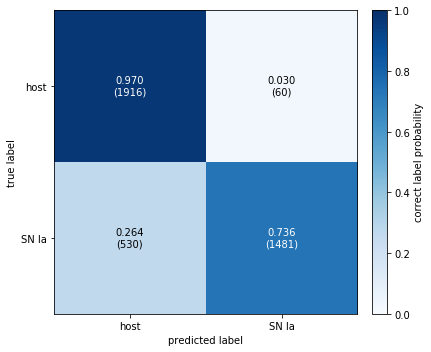

In [40]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_cv, y_pred > 0.9)
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(6,5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label probability')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=['host', 'SN Ia'],
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=['host', 'SN Ia'])

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([1.5,-.5])

fig.tight_layout()

## <font color='red'>CM with y_pred > 0.99</font> 

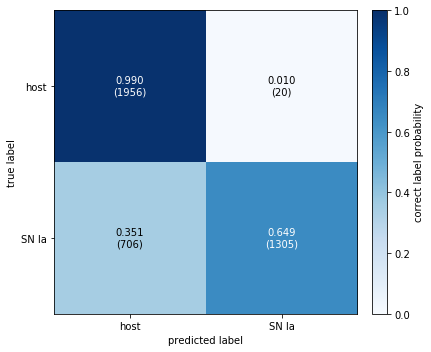

In [41]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_cv, y_pred > 0.99)
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(6,5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label probability')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=['host', 'SN Ia'],
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=['host', 'SN Ia'])

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([1.5,-.5])

fig.tight_layout()

# <font color='blue'> 70, 15, 15 split

In [48]:
x_train, a, y_train, b = train_test_split(x, y, train_size=0.7)
x_cv, x_test, y_cv, y_test = train_test_split(a,b, test_size=0.5)

len(x_train), len(x_test), len(x_cv),len(y_train), len(y_test), len(y_cv)


(13953, 2990, 2990, 13953, 2990, 2990)

In [49]:
hist = model.fit(x_train, y_train, batch_size=65, epochs=50, validation_data=(x_test, y_test), shuffle=True)

Train on 13953 samples, validate on 2990 samples
Epoch 1/50
13953/13953 [==============================] - 2s 163us/sample - loss: 0.3284 - acc: 0.9214 - val_loss: 0.2923 - val_acc: 0.9351
Epoch 2/50
13953/13953 [==============================] - 2s 156us/sample - loss: 0.2939 - acc: 0.9291 - val_loss: 0.3002 - val_acc: 0.9247
Epoch 3/50
13953/13953 [==============================] - 2s 158us/sample - loss: 0.2767 - acc: 0.9341 - val_loss: 0.3101 - val_acc: 0.9174
Epoch 4/50
13953/13953 [==============================] - 2s 159us/sample - loss: 0.2573 - acc: 0.9416 - val_loss: 0.3881 - val_acc: 0.8863
Epoch 5/50
13953/13953 [==============================] - 2s 159us/sample - loss: 0.2476 - acc: 0.9455 - val_loss: 0.3553 - val_acc: 0.9023
Epoch 6/50
13953/13953 [==============================] - 2s 159us/sample - loss: 0.2394 - acc: 0.9469 - val_loss: 0.3453 - val_acc: 0.9097
Epoch 7/50
13953/13953 [==============================] - 2s 160us/sample - loss: 0.2351 - acc: 0.9496 - val_lo

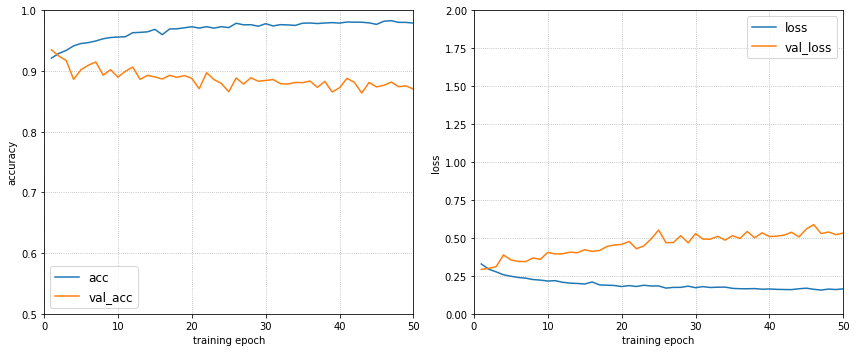

In [50]:
## Performance

### Loss and Accuracy

fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['acc'], label='acc')
ax.plot(epochs, hist.history['val_acc'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.5,1.0))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
       ylim=(0.,2.0))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

fig.tight_layout();


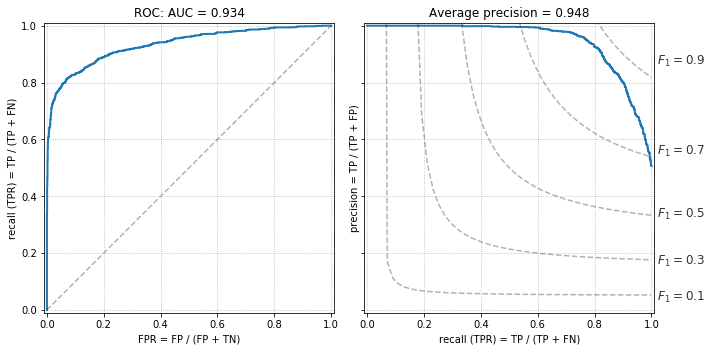

In [51]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
y_pred = model.predict(x_cv).ravel()
fpr, tpr, thresholds = roc_curve(y_cv, y_pred)
pre, rec, _ = precision_recall_curve(y_cv, y_pred)

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

ax = axes[0]
ax.plot(fpr, tpr, lw=2)
ax.plot((0,1), (0,1), 'k--', alpha=0.3)
ax.grid(ls=':')
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(auc(fpr, tpr)),
       aspect='equal')

ax = axes[1]
ax.plot(rec, pre, lw=2)
f_scores = np.linspace(0.1, 0.9, num=5)
lines = []
labels = []
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_cv, y_pred)),
       aspect='equal')

fig.tight_layout()

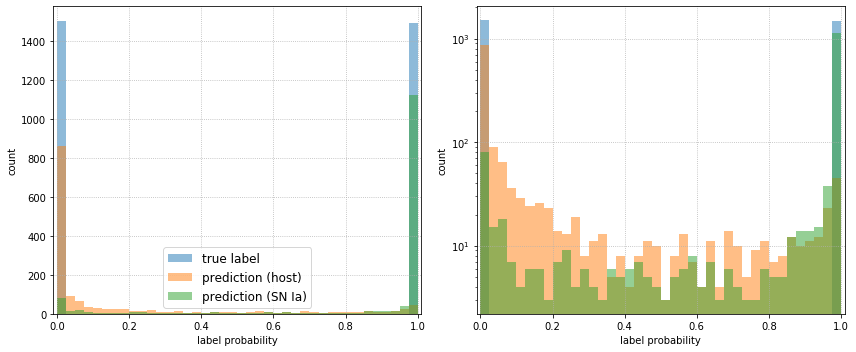

In [52]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

ax = axes[0]
ybins = np.linspace(0,1,41)
ax.hist(y_cv, bins=ybins, alpha=0.5, label='true label')
ax.hist(y_pred[y_cv==0], bins=ybins, alpha=0.5, label='prediction (host)')
ax.hist(y_pred[y_cv==1], bins=ybins, alpha=0.5, label='prediction (SN Ia)')
ax.grid(ls=':')
ax.set(xlabel='label probability',
       xlim=(-0.01, 1.01),
       ylabel='count')
ax.legend(fontsize=12, loc='best')

ax = axes[1]
ybins = np.linspace(0,1,41)
ax.hist(y_cv, bins=ybins, alpha=0.5, label='true label')
ax.hist(y_pred[y_cv==0], bins=ybins, alpha=0.5, label='prediction (host)')
ax.hist(y_pred[y_cv==1], bins=ybins, alpha=0.5, label='prediction (SN Ia)', log=True)
ax.grid(ls=':')
ax.set(xlabel='label probability',
       xlim=(-0.01, 1.01),
       ylabel='count')

fig.tight_layout()

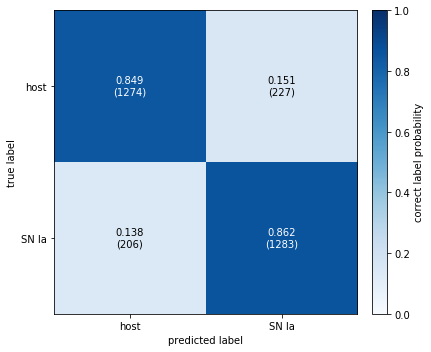

In [53]:
## <font color='red'>CM with y_pred > 0.5</font> 

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_cv, y_pred > 0.5)
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(6,5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label probability')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=['host', 'SN Ia'],
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=['host', 'SN Ia'])

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([1.5,-.5])
fig.tight_layout()